## Downloading and installing

[О среде](https://pypi.org/project/gym-super-mario-bros/)

<img src="https://pytorch.org/tutorials/_images/mario.gif" width="500">

In [ ]:
!pip install Box2D  > /dev/null 2>&1
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!apt update > /dev/null 2>&1
!pip install gym-super-mario-bros==7.3.0
!sudo apt-get install xvfb -y
!pip install xvfbwrapper
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!sudo apt-get install ffmpeg -y

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
from pathlib import Path
from collections import deque
import random, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# библиотеки для отрисовки
from PIL import Image
from IPython import display as ipythondisplay
from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
%matplotlib inline

In [ ]:
# necessary libraries for working with time
import time, datetime
from datetime import datetime as dttime
import pytz

moscow_timezone = pytz.timezone('Europe/Moscow')

In [ ]:
# Устройство, на котором будет работать PyTorch.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # GPU trains faster

if torch.cuda.is_available():
    print("Вы используете gpu, все ок")
else:
    print("Вы не используете gpu!! Если вы в google colab, выберите gpu в Runtime -> Change Runtime type")

RL Definitions

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




Initialize Environment
------------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [ ]:
# Инициализация среды
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
#   2. long jump right


RIGHT_WITH_JUMPS = [['right'], ['right', 'A'], ['right', 'A', 'B']]


env = JoypadSpace(env, RIGHT_WITH_JUMPS)
env.reset()


# next_state, reward, done, info = env.step(action=0)
# print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

In [ ]:
# как сейчас выглядит состояние
# Image.fromarray(next_state, "RGB")

## Как устроена награда

$r = v + c + d$

где 

v = x1 - x0 - разница между горизонтальной координатой агента в следующем и текущем состоянии. v > 0 если агент подвинулся вправо, v < 0 если агент подвинулся влево, v=0 если агент стоит.

c - мотивирует агента не стоять на месте (вроде негативная награда за время в игре).

d - негативная награда за смерть. d = -15 если агент умер, d = 0 иначе.

Награда ограничена между [-15, 15].

Препроцессинг
------------------------

Состояние (next_state в клетке сверху) по дефолту размером `[3, 240, 256]`. Чтобы работало быстрее, можно применить врапперы (wrappers), уменьшающие размер состояния за счет выкидывания ненужной информации типа цвета.


``GrayScaleObservation`` Сделает из цветной картинки чб, получим размер
``[1, 240, 256]``

``ResizeObservation`` Сделает картинку квадратной и поменьше, размер 
``[1, 84, 84]``. Также пиксели принимают значения от 0 до 255, нейронные сети больше любят нормализованные значения от -1 до 1 или от 0 до 1.


Кроме того, типично применять следующие два враппера. Во-первых, по статичной картинке не всегда можно определить динамику - куда движется марио или грибы или гумбы. Поэтому в качестве состояния дают 4 последних кадра с помощью враппера ``FrameStack``. Получится размер
``[1, 84, 84]``

Во-вторых, обычно агенту дают совершать действия только раз в n кадров. Потери от этого небольшие - нечасто есть необходимость менять действие каждый кадр (разве что мы тренируем frame-perfect спидранера). Плюсы - экономим вычисления, немного приближаем агента к человеку, который не может каждый кадр нажимать разную кнопку (в боте, играющем в StarCraft 2, DeepMind специально ограничивали actions per minute агента, чтобы честно сравнивать с людьми). Для этого используется враппер ``SkipFrame``. Награда, полученная за несколько кадров между действиями, накапливается и дается на n-ный кадр.

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [ ]:
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, [2, 0, 1])
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

In [ ]:
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

In [ ]:
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

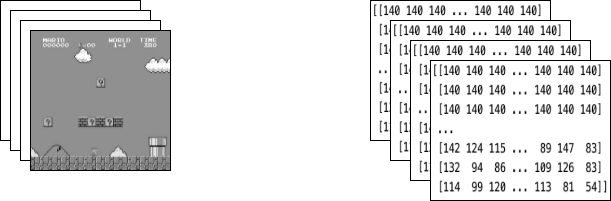

## Agent

Наш агент будет объектом класса ``Mario``. Надо имплементировать несколько методов: **act** взаимодействует со средой epsilon-greedy политикой, **learn** обучает агента на основе транзиций из буфера, **cache** и **recall** добавляет в буфер и достает из буфера транзиции вида (state, action, reward, next state, done), save и load сохраняет и загружает веса нейронной сети.

In [ ]:
class MarioNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class ExpirienceReplay():
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)
    
    def add(self, transition):
        # было (state, next_state, action, reward, done)
        # стало (state, action, reward, next_state, done)
        self.data.append((torch.tensor(transition[0].__array__()), 
                          transition[1], 
                          transition[2], 
                          torch.tensor(transition[3].__array__()), 
                          transition[4]))
        
    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [ ]:
class Mario:
    def __init__(self,
                 device,
                 episodes,
                 save_dir,
                 state_dim=(4, 84, 84),
                 action_dim=env.action_space.n,
                 sync_every=1000,
                 save_every=100000,
                 burnin=10000,
                 experience_replay_buffer=100000):
        self.device = device
        self.episodes = episodes
        self.save_dir = save_dir
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_every = save_every  # Как часто сохранять веса сети
        self.sync_every = sync_every  # Как часто обновлять target сеть
        self.burnin = burnin  # Сколько шагов инициализировать буфер без обучения
        
        self.net = MarioNet(state_dim, action_dim).to(device)  # Нейронная сеть MarioNet
        self.target_net = copy.deepcopy(self.net)  # Target сеть, обновлять можно раз в 1-10 тысяч итераций обучения если hard, каждый шаг если soft
        
        self.eps = 0.8 # Можно, чтобы в начале обучения действия были полностью рандомные,
                     # а к концу почти полностью жадные (обычно 5-10 процентов случайных действий оставляют)
        
        self.memory = ExpirienceReplay(experience_replay_buffer)  # Experience replay buffer
        
        self.curr_step = 0  # Текущий шаг взаимодействия со средой
        
        self.learn_every = 2  # Как часто обучатся, можно поварьировать. ???????
        self.gamma = 0.999  # Дискантирование ???????
        self.batch_size = 32
        self.tau = 0.002
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00025)
        


    def act(self, state, episode_id=None, explore=True):
        """
        Выбрать действие в состоянии с помощью epsilon_greedy если explore=True,
        а после понизить epsilon и прибавить step. Если explore=False, выбрать действие с помощью greedy (для эвалюации).
        """
        action_idx = None
        if explore:
            action_idx = env.action_space.sample() if self.eps > random.random() else None
            self.eps = (self.episodes - 0.5 * episode_id) / self.episodes
#             self.eps = max(0.05, (self.episodes * 0.9 - episode_id) / (self.episodes * 0.9))
#             self.eps = max(0.05, (self.episodes * 0.5 - episode_id) / (self.episodes * 0.5))
        if action_idx is None:
            with torch.no_grad():
                state = torch.tensor([state.__array__()], dtype=torch.float32, device=self.device)
                q = self.net(state)[0]
                action_idx = q.argmax().item()
        self.curr_step += 1
        return action_idx

        """
        with torch.no_grad():
            state = torch.tensor([state.__array__()], dtype=torch.float32, device=self.device)
            q = self.net(state)[0]
        action_idx = q.argmax().item()
        if explore:
            action_idx = env.action_space.sample() if self.eps > random.random() else action_idx
            # self.eps = max(0, (self.episodes * 0.9 - e) / (self.episodes * 0.9))
            self.eps = max(0.05, (self.episodes * 0.5 - e) / (self.episodes * 0.5))
        self.curr_step += 1
        return action_idx
        """

    def cache(self, experience):
        """
        Add the experience to memory - сохранить транзиции (state, action, reward, next_state, done) в буфер.
        Должны быть тензорами, хранящамися на cpu (на gpu скорее всего не влезет!).
        """
        self.memory.add(experience)

    def recall(self):
        """Sample experiences from memory - достать из буфера транзиции для обучения, склеить в батчи, перевести на device"""
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        state = torch.stack(state).to(device)
        action = torch.tensor([action], dtype=torch.int64, device=self.device)
        next_state = torch.stack(next_state).to(device)

        return state, action, reward, next_state, done  # Батч для обучения

    def sync_Q_target(self):
        self.target_net = copy.deepcopy(self.net)

    def learn(self):
        """
        Обновить Q-values на основе батча транзиций из буфера, можно dqn или модификацию
        Стркуктура обучения прописана, но все методы надо написать.
        """
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step % self.learn_every != 0 and self.curr_step > self.burnin:

            # Sample from memory - батч для обучения
            state, action, reward, next_state, done = self.recall()

            # Get TD Estimate - оценка Q-value в state-action
            td_est = self.td_estimate(state, action)

            # Get TD Target - оценка target на основе награды и дискантированного Q-value в следующем состоянии 
            # (равном нулю для терминального состояния где done=True)
            td_tgt = self.td_target(reward, next_state, done)

            # Backpropagate loss through Q_online - посчитать лосс MSE или SmoothL1Loss, обновить веса сети, не забыть про zero_grad 
            loss = self.update_Q_online(td_est, td_tgt)

            return (td_est.mean().item(), loss)

        else:
            return None

    def td_estimate(self, state, action):
        # action = torch.tensor([action], dtype=torch.int64, device=self.device)
        return self.net(state).gather(1, action).view(-1)

    def td_target(self, reward, next_state, done):
        with torch.no_grad():
            done = torch.tensor([done], dtype=torch.int64, device=self.device)
            reward = torch.tensor([reward], dtype=torch.float32, device=self.device)
            return reward + (1 - done) * self.gamma * torch.max(self.target_net(next_state), dim=1)[0]

    def update_Q_online(self, td_est, td_tgt):
        loss = F.mse_loss(td_est, td_tgt)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def save(self):
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir, parents=True)
        torch.save(self.net.state_dict(), os.path.join(self.save_dir, 'saved_model_' + str(self.curr_step) + '.pt'))
        """Сохранить веса сети в self.save_dir каждые save_every итераций обучения, torch.save в помощь"""

    def load(self):
        self.net = MarioNet(self.state_dim, self.action_dim)
        self.net.load_state_dict(torch.load('saved_model-Copy2.pt'))
        self.net = self.net.to(device)
        """Загрузить самые новые веса сети из self.save_dir, чтобы продолжить обучение, torch.load в помощь"""

## Logging

In [ ]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

## Let’s play!
For Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!




In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("Сheckpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

episodes = 10000

mario = Mario(device=device, episodes=episodes, save_dir=save_dir)
mario.load()

logger = MetricLogger(save_dir)

for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state, e)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache((state, action, reward, next_state, done))

        tmp = mario.learn()
        if tmp is not None:
            q, loss = tmp
            # Logging
            logger.log_step(reward, loss, q)


        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.eps, step=mario.curr_step)

Visualisation
--------------

In [ ]:
# подключаем дисплей
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# для сохранения видео
Writer = animation.writers['ffmpeg']
writer = Writer(fps=50, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
def init_figure():
    # для отрисовки
    fig, ax = plt.subplots(figsize=(8, 6), nrows=1, ncols=1)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tight_layout()
    return fig, ax


def show_and_download_video(frames):
    # сохраняет видео и выводит его в output ячейки
    fig, ax = init_figure()
    ims = []
    for f in frames:
        im = plt.imshow(f, animated=True)
        ims.append([im])
    anim = animation.ArtistAnimation(fig, ims, interval=25, blit=True, repeat_delay=1000)
    current_date = dttime.date(dttime.now(moscow_timezone)).strftime("%Y-%m-%d")
    current_time = dttime.now(moscow_timezone).strftime("%H-%M-%S")
    video_title = "mario_{}_{}.mp4".format(current_date, current_time)
    print("Saving video {}...".format(video_title))
    anim.save(video_title, writer=writer)
    print("Video saved successfully")
    print("Showing embedded video...")
    ipythondisplay.display(HTML(anim.to_jshtml()))
    plt.close()

    
def visualise(agent, episodes=1):
    # собирает материал для анимации
    # episodes -- количество тестов, которые хотим провести

    
    # создаём отдельную среду для визуализации, т.к. среда env, в которой работает Марио -- с обёртками,
    # которые при визуализации будут мешать
    env_to_show = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    env_to_show = JoypadSpace(env_to_show, RIGHT_WITH_JUMPS)
    env_to_show = SkipFrame(env_to_show, skip=4)

    MAX_STEPS = 0
    # print("WARNING: don't forget to count MAX_STEPS")
    for i in range(episodes):
        state = env.reset()
        done = False
        while not done:
            MAX_STEPS += 1
            state, _, done, _ = env.step(agent.act(state, explore=False))

    frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)

    current_step = 0
    for i in range(episodes):
        env_to_show.reset()
        state = env.reset()
        done = False
        # done_show = False
        # rew = 0
        while not done:
            frames[current_step] = env_to_show.render(mode='rgb_array')
            action = agent.act(state, explore=False)
            env_to_show.step(action)
            #  _, _, done_show, _ = env_to_show.step(action)
            # state, r, done, _ = env.step(action)
            #  rew += r
            state, _, done, _ = env.step(action)
            current_step += 1
            # print(current_step, action, done_show, done, rew, sep=' ')
    
    print("Animation has {} frames".format(MAX_STEPS))
    show_and_download_video(frames)

In [ ]:
# опционально -- загрузка модели из файла

# mario = Mario()
# mario.load()

In [ ]:
visualise(mario)

## Советы

- С дефолтной архитектурой сети в колабе на гпу обучение длится около суток. Надо заранее убедится, что нет багов.
- Всякие модификации имеет смысл тестировать на более простых средах (прошлые ноутбуки), прежде чем применять тут.
- Колаб дает 12 часов гпу, после чего идет принудительная перезагрузка. Поэтому надо заранее прописать сохранение и загрузку весов модели и вручную перезапустить обучение 1-2 раза.

# **Модификации**

## Логика кода
- Можно для построения графика перформанса агента иногда во время обучения прогонять отдельный скрипт эвалюации, где отключена эксплорации, скажем 100 эпизодов (при эвалюации надо переводить сеть в .eval() режим, после обратно в .train()). Можно помимо графиков сохранять и видео (но не спамить ими). Можно подумать как еще визуализировать результаты для презентации.
- Можно попробовать разпаралелить для ускорения обучения. Во-первых, можно в act паралельно взаимодействовать с несколькими инстансами среды и так быстрее собирать experience (по сути вместо одного state, action, next_state, будет список из states, агент возвращает список actions, а среда в ответ на них список next_states). Во-вторых, можно асинхронно (паралельно) взаимодействовать со средой и обучаться, а не по очереди, как сейчас. Для этого есть библиотека ray. Можно прикинуть, сколько это времени обучения сохранит, сравнив время, затрачиваемое на взаимодействие со средой и на обучение. Вроде colab дает две cpu, на 2 процесса должно хватить, а gpu нужно только при обучении.

## Нейронная сеть
- Dropout между Linear слоями в конце сетки - регуляризация, обнуляет какую-то долю нейронов (типа 0.1), иногда помогает (разное поведение при .train() и .eval() режимах сети!)
- l2 regularization - в оптимизаторе weight decay
- learning rate decay - инициализировать learning rate побольше и уменьшать по мере обучения, как с эксплорацией, есть для этого torch.optim.lr_scheduler.StepLR
- architecture - количество слоев, нейронов
- Функция ошибки - вместо MSE loss порой используют SmoothL1Loss (MSE if td < 1, MAE else)

## [Rainbow](https://arxiv.org/abs/1710.02298) - DQN + 6 модификаций

Имплементации можно искать в интернете, но надо разобраться и адаптировать под ваш код.

### 1. Double, 2. Dueling

см предыдущий ноутбук

### 3. n-step target

Например, 3-step target выглядит так:

$y_t = r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \gamma^3 \max_{a_{t+3}} Q(s_{t+3}, a_{t+3})$

В этом случае надо либо в буфере хранить информацию по другому (next_state теперь через n шагов, reward как сумма дискантированных наград за n шагов, done указывает если за n шагов траектория прервалась), либо по-другому доставать транзиции из буфера (на каждую транзицию надо достать еще n-1 транзиций после нее и правильно обработать).



### 4. Prioretized Experience Replay

Сейчас из буфера транзиции достаются равновероятно. Но какие-то транзиции могут быть более полензы других. Польза транзиции, например, может измеряться в ошибке TD Error (квадрат которой используется как loss). Буфер, из которого транзиции достаются пропорционально ошибке, называется приоритезированным. Но если по-другому доставать транзиции, агент может редко обучаться на важных состояниях, которые видит часто, и наоборот - в отличие от обычного буфера. Поэтому каждой транзиции в лоссе сопостовляется вес, обратно пропорциональный вероятности вытаскивания этой транзиции из буфера. Подробнее можно почитать в [статье](https://arxiv.org/abs/1511.05952).

Вероятность сэмплирования транзиции считается через приоритет так:

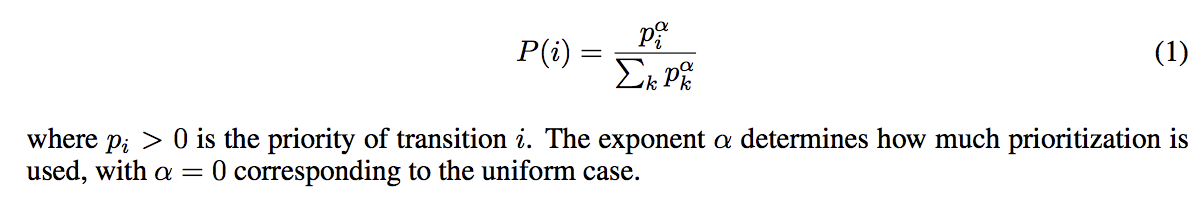

Вес в лоссе, соответсвующий транзиции, считается так:

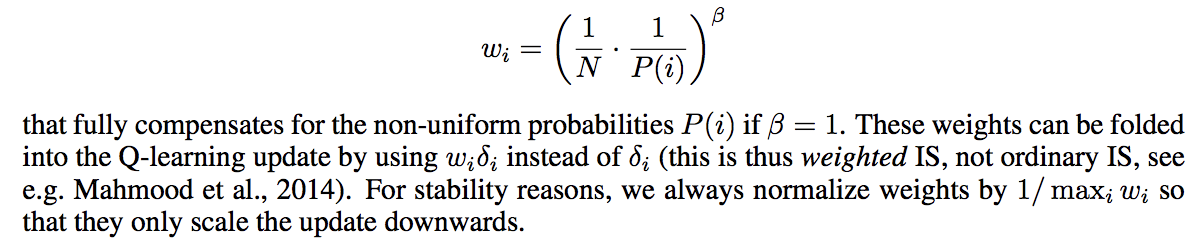



### 5. Noisy

Это более продвинутый метод эксплорации, чем epsilon-greedy (впрочем, можно использовать и то и то). Заменяем скрытый Linear слой на специальный NoisyLinear слой, который возвращает случайные значения. Этот шумный слой предсказывает среднее и дисперсию нормального распределения, из которого сэмплируется выход слоя (линейный слой в этой нотации предсказывает только среднее и имеет дисперсию 0). 
Подробнее в [статье](https://arxiv.org/abs/1706.10295).


Сравнение линейного и шумного слоев:

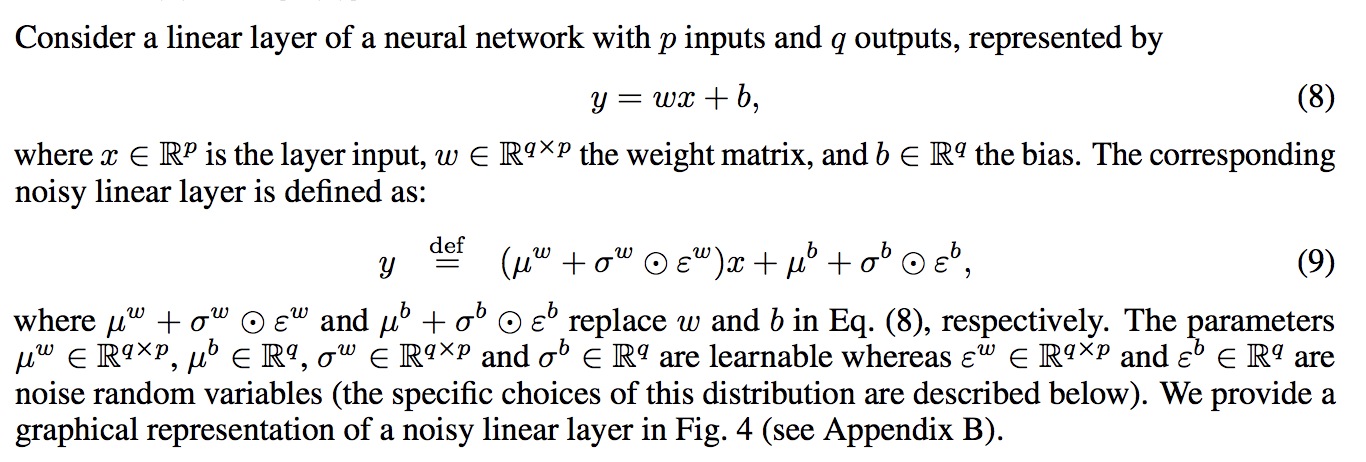


### 6. Distributional

Ванильный DQN предсказывает Q-value в среднем (ожидание). На самом деле есть какое-то распределение у return - с такой-то вероятностью можно получить столько-то. Как повезет - зависит от политики агента (если она стохастическая) и от динамики среды (тоже может быть стохастической). Distributional DQN предсказывает много разных значений, соответствующих квантилям Q-value. Например, научим сеть предсказывать 99 значений return таких, что 1-ое значение можно получить если не очень повезет (такой return или меньше вероятность получить 1%), 2-ое значение можно получить если не повезет чуть меньше (такой return или меньше вероятность получить 2%), ..., 99 значение можно получить если очень повезет (такой return или больше вероятность получить 1%). Усредним по этим 99 значениям - и получим среднее Q-value, которое можно использовать для принятия решений как и раньше. Но якобы обучение более стабильное. Как это обучать - с помощью так называемых quantile loss, по сути наклоненная mae. Подробнее в [статье](https://arxiv.org/abs/1710.10044).



## Обучение на демонстрациях (Imitation Learning, Learning from Demonstrations)

Можно обучать агента не с нуля, а использовать демонстрации - то есть у агента будет пример неплохого поведения в среде. Для этого надо написать скрипт сбора демонстраций - ручками поиграть в Марио (у меня есть такой скрипт для игры montezuma revenge, тоже в gym). После сбора можно для начала обучить агента имитировать демонстрации вообще без обучения на награде среды. Behavioural Cloning - самый простой метод для этого, просто обучим supervised классификатор предсказывать действия, совершаемые в демонстрациях - также, как мы классифицировали цифры в mnist. Взаимодействия со средой в этом случае нет. [Пример](https://www.youtube.com/watch?v=p01vWk7uMvM) как такой агент обучился на людских демонстрациях играть в cs 1.6. Дальше агента можно попробовать дообучить в среде на награде - человеческие демонстрации не идеальны. А можно инициализировать буфер DQN демонстрациями, как делают [тут](https://arxiv.org/abs/1704.03732).

## Advanced exploration

Помимо Noisy или epsilon-greedy эксплораций можно попробовать [Boltzmann exploration](https://www.oreilly.com/library/view/hands-on-reinforcement-learning/9781788836524/97edf745-4286-4116-95f0-b3fbb52d1070.xhtml) (там надо температуру тюнить), curiosity-driven exploration (их много, можно гуглить, вот [например](https://medium.com/data-from-the-trenches/curiosity-driven-learning-through-next-state-prediction-f7f4e2f592fa)).

## Actor-Critic

Отличный от DQN способ обучать агента, можно сравнить. Используются две сетки: Actor предсказывает политику $\pi(s, a)$, Critic предсказывает value функцию $V(s)$ и помогает Actor обучаться. Про это много постов, например [вот](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f).